<a href="https://colab.research.google.com/github/machine-perception-robotics-group/ImageProcessingGoogleColabNotebooks/blob/master/04_hough_fourier_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. ハフ変換，フーリエ変換

講義で説明する画像処理の方法について，google colaboratoryを利用して演習する．
google colaboratoryは，クラウドで実行する Jupyter ノートブック環境である.
google coraboratoryについては，[ここ](https://www.tdi.co.jp/miso/google-colaboratory-gpu)や[ここ](https://www.codexa.net/how-to-use-google-colaboratory/)を参考にすること．

下記のプログラムを実行すると，ハフ変換による直線や円の検出，フーリエ変換による画像の周波数領域表現の獲得，ローパスフィルタ，ハイパスフィルタを行う．

## 準備
プログラムの動作に必要なデータをダウンロードする．

In [0]:
!wget -q http://www.mprg.cs.chubu.ac.jp/Tutorial/ML_Lecture/tutorial_ip_2020/image1.zip
!unzip -q image1.zip
!ls
!ls ./image1

image1	image1.zip  sample_data
168065B.JPG	 Blackboard3.jpg  woman-color.jpg  woman-n.jpg
Blackboard1.jpg  coin.png	  woman-g2.jpg	   woman-s.jpg
Blackboard2.jpg  ipod.png	  woman-g.jpg	   woman-t.jpg


## 画像の読み込みと表示
必要なパッケージをインポートし，画像を表示する．

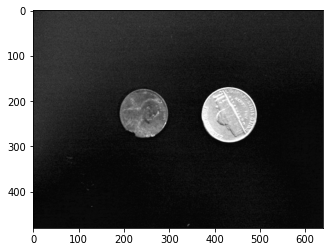

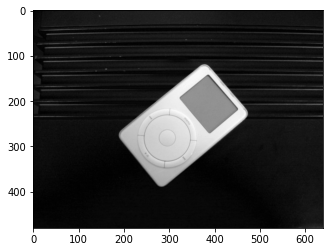

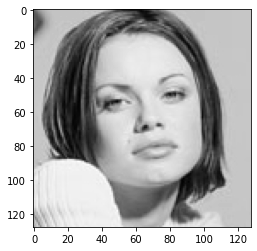

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('./image1/coin.png', 0)
img2 = cv2.imread('./image1/ipod.png', 0)
img3 = cv2.imread('./image1/woman-t.jpg', 0)

plt.imshow(img1, cmap="gray")
plt.show()
plt.imshow(img2, cmap="gray")
plt.show()
plt.imshow(img3, cmap="gray")
plt.show()

## ハフ変換

ハフ変換では，画像中の直線や円を検出する．

### 直線の検出

はじめにソーベルフィルタによるエッジの検出と検出したエッジの2値化を行う．

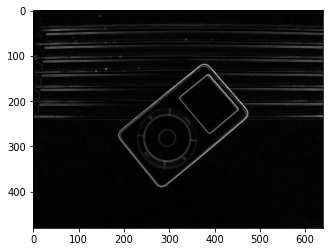

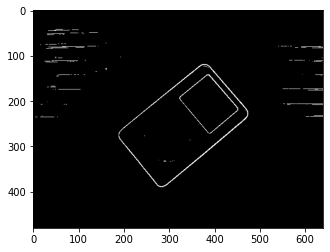

In [0]:
img = img2.copy()

# ソーベルフィルタによるエッジ検出
img_sobel_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
img_sobel_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
img_sobel = np.sqrt(img_sobel_x**2 + img_sobel_y**2)
img_sobel = np.abs(img_sobel)
plt.imshow(img_sobel, cmap="gray")
plt.show()

# 検出したエッジを二値化
img_binary = img_sobel.copy()
img_binary[img_sobel <= 200] = 0
img_binary[img_sobel > 200] = 255
plt.imshow(img_binary, cmap="gray")
plt.show()

検出したエッジを用いて，直線を検出する．

検出にはOpenCVの`HoughLinesP`関数を使用する．
`HoughLinesP`関数では，検出に使用する画像（今回は2値化したエッジ画像）と投票空間の距離と角度の分解能，最小の線分長，および2点が同一線分上にあると見なす場合に許容される最大距離を引数として入力する．

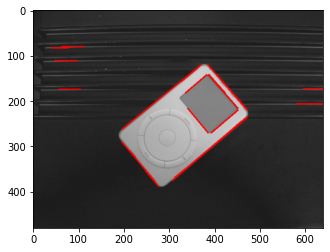

In [0]:
# 検出する最小の線分長
minLineLength = 100
# 2点が同一線分上にあると見なす場合に許容される最大距離
maxLineGap = 10

# 確率的ハフ変換を利用した線分検出
lines = cv2.HoughLinesP(img_binary.astype(np.uint8), 1, np.pi/180, 60, minLineLength, maxLineGap)

# 結果を描画するための画像を準備
img_result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# 検出した線分を一つづつ描画
for l in lines:
  x1, y1, x2, y2 = l[0]
  img_result = cv2.line(img_result, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img_result)
plt.show()

### 円の検出

続いて，円の検出を行う．



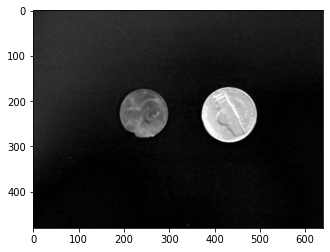

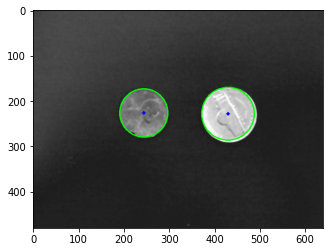

In [0]:
# 円検出する画像を読み込んで，メディアンフィルタを適用する
img = img1.copy()
img = cv2.medianBlur(img, 5)
plt.imshow(img, cmap="gray")
plt.show()

# 円の検出
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=50, param2=60, minRadius=0, maxRadius=0)

# 結果を描画するための画像を準備
img_result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# 検出した円の描画
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    # 円を描画
    cv2.circle(img_result, (i[0], i[1]), i[2] ,(0, 255, 0), 2)
    # 円の中心を描画
    cv2.circle(img_result, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.imshow(img_result)

## フーリエ変換

画像処理におけるフーリエ変換は画像の表現方法を空間領域から周波数領域へ変換する処理である．
画像の周波数領域変換は，2次元の離散フーリエ変換（2D-DFT）を適用することで実現される．

以下では，離散フーリエ変換を行う．

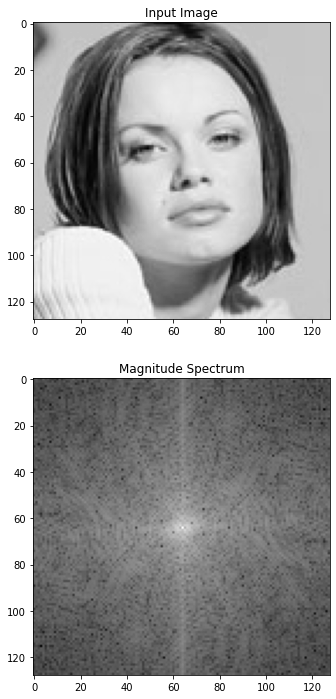

In [0]:
img = img3.copy()

# 2次元のフーリエ変換
img_fft = np.fft.fft2(img)

# 直流成分が画像の中心に位置するよう移動（第1象限と第3象限、第1象限と第4象限を入れ替え）
img_fft2 = np.fft.fftshift(img_fft)

# 表示用に値を変換
magnitude_spectrum = np.log(np.abs(img_fft2))

# 結果の表示
plt.figure(figsize=(8, 12))
plt.subplot(211), plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.subplot(212), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()

#### ローパスフィルタ

画像には低周波成分が多く含まれており，高周波成分は低周波成分と比べ少ないという特徴がある．
そこで，ローパスフィルタでは，画像の低周波成分のみを残し，それ以外の高周波成分を削除するフィルタ処理の一種である．



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


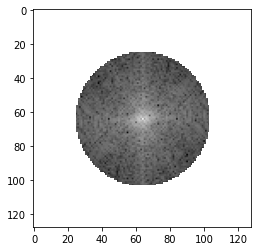

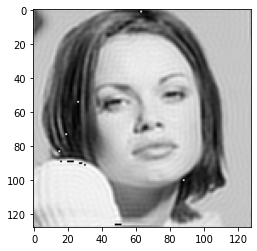

In [0]:
# フィルタサイズ（円の半径）を指定
r = 40

# 画像を用意しフーリエ変換を適用（上のプログラムと同様）
img = img3.copy()
img_fft = np.fft.fft2(img)
# 直流成分が画像の中心に位置するよう移動（第1象限と第3象限、第1象限と第4象限を入れ替え）
img_fft2 = np.fft.fftshift(img_fft)

# 画像サイズの取得
h, w = img_fft.shape
# 画像の中心座標の取得
cy, cx = int(h/2), int(w/2)

# rh, rw = int(0.3*cy), int(0.3*cx)

# ローパスフィルタ後の値を保存するための配列を用意
lowpass = np.zeros(img_fft.shape, dtype=complex)

# 中心部分の値だけ代入（中心部分以外は0のまま）
for y in range(h):
  for x in range(w):
    if np.sqrt((x - cx)**2 + (y - cy)**2) < r:
      lowpass[y, x] = img_fft2[y, x]

# ローパスフィルタを適用した周波数成分の表示
plt.imshow(np.log(np.abs(lowpass)), cmap="gray")
plt.show()

# 第1象限と第3象限、第1象限と第4象限を入れ替え
lowpass = np.fft.fftshift(lowpass)
# 周波数成分からの画像の再構成（逆フーリエ変換）
img_lowpass = np.fft.ifft2(lowpass)
# 複素数表現の実部のみを取り出す
img_lowpass = np.uint8(img_lowpass.real)

# 再構成した画像の表示
plt.imshow(img_lowpass, cmap="gray")
plt.show()

#### ハイパスフィルタ

ハイパスフィルタはローパスフィルタとは逆に高周波成分のみを残すようなフィルタ処理の一種である．



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


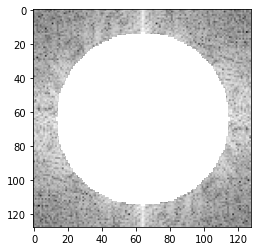

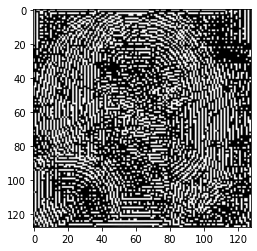

In [0]:
# フィルタサイズ（円の半径）を指定
r = 50

# 画像を用意しフーリエ変換を適用（上のプログラムと同様）
img = img3.copy()
img_fft = np.fft.fft2(img)
# 直流成分が画像の中心に位置するよう移動（第1象限と第3象限、第1象限と第4象限を入れ替え）
img_fft2 = np.fft.fftshift(img_fft)

# 画像サイズの取得
h, w = img_fft.shape
# 画像の中心座標の取得
cy, cx = int(h/2), int(w/2)

# ローパスフィルタ後の値を保存するための配列を用意
highpass = np.zeros(img_fft.shape, dtype=complex)

# 中心部分の値だけ代入（中心部分以外は0のまま）
for y in range(h):
  for x in range(w):
    if np.sqrt((x - cx)**2 + (y - cy)**2) > r:
      highpass[y, x] = img_fft2[y, x]

# ローパスフィルタを適用した周波数成分の表示
plt.imshow(np.log(np.abs(highpass)), cmap="gray")
plt.show()

# 第1象限と第3象限、第1象限と第4象限を入れ替え
highpass = np.fft.fftshift(highpass)
# 周波数成分からの画像の再構成（逆フーリエ変換）
img_highpass = np.fft.ifft2(highpass)
# 複素数表現の実部のみを取り出す
img_highpass = np.uint8(img_highpass.real)

# 再構成した画像の表示
plt.imshow(img_highpass, cmap="gray")
plt.show()

## 課題


* ハフ変換に使用される関数`cv2.HoughLinesP`,`cv2.HoughCircles`の引数を変更し，変化を確認すること
* ローパスフィルタ，ハイパスフィルタのフィルタサイズ`r`を変更し，変化を確認すること